In [239]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

import pandas as pd
from torch.utils.data import Dataset

from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import torch.autograd as autograd

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import csv
torch.manual_seed(8)

In [240]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__() ## importing class from super
        self.model = nn.Sequential(
            nn.Linear(1050, 512), ## Note this is because there is 1050 inputs
            #nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2), #increased size for first layer
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            #nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2), #Uses ReLU activation
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            #nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1), #Last layer goes from 64 neurons to 1
            nn.Sigmoid(), ##using sigmoidal activation to create a single neuron output
        )
    def forward(self, x):
            output = self.model(x) #describes how the output of the model is calculated
            return output 
#discriminator = Discriminator()

In [241]:
class Generator(nn.Module): # Inherits from the nn.Module
    def __init__(self, noise_dim = 100):
        super().__init__() ##allows you to create a nn architecture
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256), ## taking noise vector of 100 to have more diversity
            #nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            #nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2), # Leaky ReLU prevents overfitting, especially since the sample sets have been relatively small
            nn.Linear(512, 1024), 
            #nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1050),  # Output layer producing 1050 features
            nn.Tanh()
        )

    def forward(self, x):
        output = self.model(x)
        return output


In [245]:
class GANDataHandler:
    def __init__(self, features, batch_size = 128, lr = .001):
        self.scaler = MinMaxScaler() # Scaler. Used to fit transform data for the GANS and inverse transform to transform it back to GANS "size"
        self.features = features # MS Data
        self.batch_size = batch_size # # of samples being input at a time
        self.lr = lr # Learning Rate of the GANS

        ## Preprocessing Variables ##
        # Real Data used for training #
        self.real_data = None 
        self.real_labels = None
        self.real_set = None
        self.real_data_loader = None  # Dataloader to be used in training
        self.USIDs = None # USIDS will be merged later
        self.metadata = None
        
        ## Generator and Discriminator ##
        self.generator = None
        self.discriminator = None

        ## Training Metrics to be Displayed by Classification Report ##
        # Average Loss over all training 
        self.avg_loss_g = None
        self.avg_loss_d = None
        # Number of Epochs trained on
        self.num_epochs_trained = 0
        # Average Accuracy of the Discriminator
        self.avg_disc_acc = None
        self.avg_gen_acc = None

  
    """ preprocess_data()
    Preprocesses the features data by scaling and creates a DataLoader for use in model training or evaluation. Saves USIDS and Meta Data to be merged later.

    Steps:
    1. Scale the feature data using the scaler's fit_transform method.
    2. Generate labels for the real data.
    3. Create a dataset by zipping together the scaled data and the corresponding labels.
    4. Initialize a DataLoader with the created dataset, setting the batch size and shuffling the data.
    
    This method is used after GANS is created;

    test = GANDataHandler(ms_data)
    test.preprocess_data
    
    """
    def preprocess_data(self):
        
        self.meta_data = self.features.loc[:,'Laser_Energy':'formationprocess_label']
        self.features.drop(self.features.loc[:,'Laser_Energy':'formationprocess_label'].columns, axis = 1, inplace = True)
        
        self.USIDs = self.features['USID'].copy()
        self.features = self.features.drop(columns = ['USID'])

        ## Preprocess data to be trained
        num_rows_to_drop = self.features.shape[0] % 512
        # Get the index of the rows to drop
        rows_to_drop = self.features.tail(num_rows_to_drop).index
        # Drop the rows
        self.features = self.features.drop(rows_to_drop)
        
        self.real_data = self.scaler.fit_transform(self.features)
        real_data_length = len(self.real_data)
        self.real_labels = torch.zeros(real_data_length)

        real_set = [ ## Zipping together labels and data to be used later
            (self.real_data[i], self.real_labels[i]) for i in range(real_data_length)
        ]
        
        self.real_data_loader = torch.utils.data.DataLoader(
            real_set, batch_size = self.batch_size, shuffle = True
        ) 
        
    """ display_features()
    Displays a graph of the feature data for a specified entry.

    This method plots the mass spectrometry data for a given entry, showing the intensity against the m/z (mass/charge ratio).

    Use:
    print(test.head()) #to find ids to input
    test.display_features(test_id)
    
    """
    def display_features(self, id):
        #entry = self.features[] ##Graphing of what our data should look like!
        print(self.features.head())
        entry = self.features.loc[id]
        plt.figure(figsize=(12, 6))
        plt.plot(entry)
        plt.title('Mass Spectrometry Data - 50th Entry')
        plt.xlabel('m/z (mass/charge ratio)')
        plt.ylabel('Intensity')
        plt.xticks(ticks=range(0, len(entry), 200))  # Show every 50th label

        plt.show()
    
    """ setup_optimizers()
    Sets up the loss function and optimizers for the discriminator and generator models.

    This method initializes the binary cross-entropy loss function and the Adam optimizers for both the discriminator and generator. 
    The learning rate for the generator's optimizer is set to be twice that of the discriminator's.

    Note: This is done within the train_model method, so this will not be needed to be called by the user
    """
    def setup_optimizers(self, discriminator, generator):
        loss_function = nn.BCELoss()
        optimizer_d = torch.optim.Adam(discriminator.parameters(), lr = self.lr) ## Adam is the name of the optimizer we will use for the discriminator and generator
        optimizer_g = torch.optim.Adam(generator.parameters(), lr = self.lr * 2)

        return loss_function, optimizer_d, optimizer_g

    
    """ train_model()
    Trains the discriminator and generator models over a specified number of epochs.

    This method initializes the discriminator and generator models, sets up the optimizers and loss function,
    and trains the model.

    This method also keeps track of batch accuracy and other metrics to be displayed later
    
    Note: This method will be called by the user after creating the GANS and preprocessing the data
    """
    def train_model(self, num_epochs):
        discriminator = Discriminator()
        generator = Generator()
        loss_function, optimizer_d, optimizer_g = self.setup_optimizers(discriminator, generator)

        #Reset Batch Loss
        self.avg_loss_g, self.avg_loss_d = None, None
        self.avg_disc_acc, self.avg_gen_acc = None, None
        # Number of Epochs trained on
        self.num_epochs_trained = 0

        for epoch in range(num_epochs):

            NOISE_DIM = 100

            total_loss_d = 0
            total_loss_g = 0

            total_correct_d = 0
            total_samples_d = 0
            
            for n, (real_samples, _) in enumerate(self.real_data_loader):
                
                fake_labels = torch.zeros((self.batch_size, 1))
                real_labels = torch.ones((self.batch_size, 1))
                
                latent_space_samples = torch.randn((self.batch_size, NOISE_DIM))
                generated_samples = generator(latent_space_samples)
        
                all_samples = torch.cat((real_samples.to(torch.float32) , generated_samples.to(torch.float32)))
                all_sample_labels = torch.cat(
                    (real_labels, fake_labels)
                )
                all_sample_labels = all_sample_labels
                
                
                #Train the discriminator
                discriminator.zero_grad() # clear gradients at each step to avoid accumulation
                output_discriminator = discriminator(all_samples) #calculate output of the batch
                #print(output_discriminator.shape, all_sample_labels.shape)
                loss_discriminator = loss_function(
                    input = output_discriminator.view(-1), target = all_sample_labels.view(-1) ##loss function
                )
                loss_discriminator.backward() #calculate gradients to update weights (gradient descent)
                optimizer_d.step() #optimizer_discriminator.step()

                #calculate optimizer accuracy
                predicted_labels = (output_discriminator > 0.5).float()
                total_correct_d += (predicted_labels == all_sample_labels).sum().item()
                total_samples_d += all_sample_labels.size(0)
                
                #Time to train the generator
                
                #data for generator
                latent_space_samples = torch.randn((self.batch_size, NOISE_DIM))
        
                #Training the generator
                generator.zero_grad()
                generated_samples = generator(latent_space_samples)
                output_discriminator_generated = discriminator(generated_samples)
                loss_generator = loss_function(
                    output_discriminator_generated, real_labels
                )
                loss_generator.backward()
                optimizer_g.step()

                total_loss_d += loss_discriminator
                total_loss_g += loss_generator
                

                 # Show loss
                if epoch % 10 == 0 and n == 5:
                    print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
                    print(f"Epoch: {epoch} Loss G.: {loss_generator}")

            #save generator and discriminator
            self.generator = generator
            self.discriminator = discriminator
            
            #Update Loss with updated batch loss
            batch_len = len(self.real_data_loader)
            batch_loss_g = total_loss_g / batch_len
            batch_loss_d = total_loss_d / batch_len

            #Update Avg Discriminator and Generator Accuracy for the current batch:
            avg_disc_acc = total_correct_d / total_samples_d
            
            fake_labels_for_gen_acc = torch.ones((self.batch_size, 1))
            output_discriminator_generated = discriminator(generated_samples)
            gen_pred_labels = (output_discriminator_generated > 0.5).float()
            gen_acc = (gen_pred_labels == fake_labels_for_gen_acc).sum().item() / self.batch_size

            self.num_epochs_trained += 1
            
            if not self.avg_loss_g and not self.avg_loss_d:
                self.avg_loss_g = batch_loss_g
                self.avg_loss_d = batch_loss_d
                self.avg_disc_acc = avg_disc_acc
                self.avg_gen_acc = gen_acc
                
            else:
                self.avg_loss_g = (batch_loss_g + (self.avg_loss_g * (self.num_epochs_trained - 1)))/self.num_epochs_trained
                self.avg_loss_d = (batch_loss_d + (self.avg_loss_d * (self.num_epochs_trained - 1)))/self.num_epochs_trained
                self.avg_disc_acc = (avg_disc_acc + (self.avg_disc_acc * (self.num_epochs_trained - 1)))/self.num_epochs_trained
                self.avg_gen_acc = (gen_acc + (self.avg_gen_acc * (self.num_epochs_trained - 1)))/self.num_epochs_trained


    """ generate_samples()
    Generates synthetic samples using the trained generator model and saves them to a CSV file.

    This method generates samples from the latent space, transforms them back to the original scale,
    applies a moving average smoothing, and saves the results to a CSV file along with metadata.
    """
    def generate_samples(self, num_samples):
      
   
        latent_space_samples = torch.randn(num_samples, noise_dim) #100 is number of samples to make
        generated_samples = self.generator(latent_space_samples)
        generated_samples = generated_samples.detach()
        generated_samples = self.scaler.inverse_transform(generated_samples)
        graphed = generated_samples.clip(min = 0)
        
        def moving_average(df, window_size):
            return df.rolling(window=window_size).mean()

        # Example usage
        graphed = moving_average(graphed, window_size=3)
    
    
        DF = pd.DataFrame(graphed) 
        DF.insert(0, 'GUSID', USID)
            
        for col in metadata.columns:
            DF[col] = metadata[col]
    
    
        DF.to_csv(f"./generated_samples/{CATEGORY_TYPE}_batch_{i}.csv")
        
        
        
        
        # Select a few spectra to plot
        num_spectra_to_plot = 4
        spectra_indices = [ 8, 9, 10] # Change these indices to plot different spectra
        
        plt.figure(figsize=(12, 6))
        
        for i in spectra_indices:
            plt.plot(graphed[i], label=f'Spectrum {i+1}')
        
        plt.title("Mass Spectra")
        plt.xlabel("Mass/Charge (m/z)")
        plt.ylabel("Intensity")
        plt.legend()
        plt.show()

    
    """ generate_classification_report()
    Generates and saves a classification report summarizing the training performance of the generator and discriminator models.

    This method prints the average generator and discriminator losses and accuracies, calculates the total number of samples trained,
    and saves these metrics to a CSV file.
    
    """
    def generate_classification_report(self, output_csv = 'classification_report.csv'):

        # Average Loss over all training 
        print(f"Average Generator Loss over {self.num_epochs_trained} Epochs: {self.avg_loss_g}")
        print(f"Average Discriminator Loss over {self.num_epochs_trained} Epochs: {self.avg_loss_d}")

        print(f"Average Generator Accuracy from the last train: {self.avg_gen_acc}")
        print(f"Average Discriminator Accuracy from the last train: {self.avg_disc_acc}")

        total_samples_trained = self.batch_size * self.num_epochs_trained

        with open(output_csv, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['Metric', 'Value'])
                writer.writerow(['Average Generator Loss', self.avg_loss_g.item()])
                writer.writerow(['Average Discriminator Loss', self.avg_loss_d.item()])
                writer.writerow(['Average Generator Accuracy', self.avg_gen_acc])
                writer.writerow(['Average Discriminator Accuracy', self.avg_disc_acc])
                writer.writerow(['Total Samples Trained', total_samples_trained])
        
        print(f"Classification report saved to {output_csv}")
        # Average Accuracy of the Discriminator


    """ export_models()
    Exports the trained generator and discriminator models to the specified directory.

    This method saves the state dictionaries of the generator and discriminator models to the specified directory
    with filenames based on the given sample name.
    """
    def export_models(self, sample_name, directory):
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        generator_path = os.path.join(directory, f'{sample_name}_generator.pth')
        discriminator_path = os.path.join(directory, f'{sample_name}_discriminator.pth')
        
        torch.save(self.generator.state_dict(), generator_path)
        torch.save(self.discriminator.state_dict(), discriminator_path)
        
        print(f'Models saved in directory: {directory}')

       
   
    
       

In [246]:
FILEPATH = './test_sample1.csv'

"""
CATEGORY_TYPE = ['Pure Inorg. Standards', 'Pure Mineral (Carbonates)', 'Pure Mineral (Clays/Silicates)', 'Pure Mineral (Oxides/Oxide-hydroxide)', 'Pure Mineral (Sulfates)', 'Pure Org. Standards', 'Real world sample', 'Spiked Minerals']
COLUMN = 'category_label'
"""
labels = {'Akaganeite': 0, 'Analog/Mixture': 1, 'Analog/real world': 2, 'Angiotensine+CHCA': 3, 'Anhydrite': 4, 'Atacama': 5, 'Augite': 6, 'BetaCarotene+FS121': 7, 'Butterfinger': 8, 'CHCA': 9, 'CaSiO3': 10, 'Calcite': 11, 'Chlorophyll A': 12, 'CsI': 
13, 'CsI in Hematite': 14, 'CsI in Mont': 15, 'DGDG': 16, 'Diopside': 17, 'Dolomite': 18, 'Enstatite': 19, 'Epsomite': 20, 'FS121': 21, 'FeSO4.7H2O': 22, 'Feldspar': 23, 'Ferrosilite': 24, 'Fluorapatite': 25, 'Forsterite': 26, 'Gabion Basalt': 27, 'Glu in Mont': 28, 'Gly+Ala+Ser mixture + CHCA': 29, 'Graphite': 30, 'Gypsum': 31, 'Hematite': 32, 'Hopane': 33, 'JSCMars-1': 34, 'Kaolinite': 35, 'Kerogen (Type IV)': 36, 'Labradorite': 37, 'Lizardite': 38, 'MGDG': 39, 'Magadi': 40, 'Magadi kerogen': 41, 'Magnetite': 42, 'MgCl2': 43, 'MgSO4': 44, 'Microcline': 45, 'Mix in Mont': 46, 'MnSO4': 47, 'Montmorillonite': 48, 'Murchison': 49, 'Nontronite': 50, 'Ocean World Analog': 51, 'Olivine': 52, 'Orthoclase': 53, 'Phe in CaSO4.H2O': 54, 'Phe in Gypsum': 55, 'Phe in Hematite': 56, 'Phe in MgSO4': 57, 'Phe in Mont': 58, 'Phe in Mont + Mg Perc.': 
59, 'Phospholipids': 60, 'Phosphorus': 61, 'Phthalic Acid in Gypsum': 62, 'Phthalic Acid in Hematite': 63, 'Phthalic Acid in MgSO4': 64, 'Phthalic Acid in Mont': 65, 'Phthalic Acid in Mont + Mg Perc.': 66, 'Porphyrin in Gypsum': 67, 'Porphyrin in Mont': 68, 'R6G in Gypsum': 69, 'R6G in Mont': 70, 'Rhodamine 6G': 71, 'Ripidolite': 72, 'Sanidine': 73, 'Saponite': 74, 'SiO2': 75, 'Thin section (C coating)': 76, 'TiO2': 77, 'Valine in Jerosite': 78, 'Vermiculite': 79, 'Yellowstone Green stream TLE': 80, 'Yellowstone Green stream powder': 81}

COLUMN = 'sample_label'
SAMPLE_TYPE = list(labels.keys())


## The plan is to try to store everything in an array of things


training_data = pd.read_csv(FILEPATH)
training_data.drop(training_data.loc[:,'1050':'2000'].columns, axis = 1, inplace = True)
training_dict = dict()
not_enough = []
for sample_label in SAMPLE_TYPE:

    # we are not training on any empty sets
    if training_data.loc[training_data[COLUMN] == sample_label].empty:
        continue
    if training_data.loc[training_data[COLUMN] == sample_label].shape[0] < 512:
        not_enough.append((sample_label,training_data.loc[training_data[COLUMN] == sample_label].shape[0]))
        continue
   
    curr = training_data.loc[training_data[COLUMN] == sample_label].copy()
    print(sample_label, curr.shape)

    #make the GAN Class
    features = curr
    training_dict[sample_label] = GANDataHandler(features = features)
    training_dict[sample_label].preprocess_data()
    

Atacama (850, 1062)
Calcite (532, 1062)
CsI (6789, 1062)
Diopside (980, 1062)
Enstatite (766, 1062)
FeSO4.7H2O (621, 1062)
Feldspar (1425, 1062)
Ferrosilite (697, 1062)
Forsterite (1228, 1062)
Gypsum (2410, 1062)
Hematite (3754, 1062)
Magadi (537, 1062)
Ocean World Analog (701, 1062)
Phe in Mont (824, 1062)
Phthalic Acid in Mont (556, 1062)
Sanidine (1108, 1062)
Thin section (C coating) (529, 1062)
TiO2 (3045, 1062)
Yellowstone Green stream TLE (653, 1062)
Yellowstone Green stream powder (991, 1062)


In [247]:
ti02 = training_dict['TiO2']
print(ti02.features.shape)

ti02.train_model(num_epochs = 5)
ti02.generate_classification_report('ti02_classification_report.csv')

(2560, 1050)
Epoch: 0 Loss D.: 0.6929782629013062
Epoch: 0 Loss G.: 0.7411906719207764
Average Generator Loss over 5 Epochs: 2.2595458030700684
Average Discriminator Loss over 5 Epochs: 0.5644510388374329
Average Generator Accuracy from the last train: 0.28125
Average Discriminator Accuracy from the last train: 0.7352343749999999
Classification report saved to ti02_classification_report.csv


In [184]:
ti02.train_model(num_epochs = 80)

Epoch: 0 Loss D.: 0.6959182024002075
Epoch: 0 Loss G.: 0.7670994997024536
Epoch: 10 Loss D.: 0.5143333673477173
Epoch: 10 Loss G.: 1.0963597297668457
Epoch: 20 Loss D.: 0.3724256455898285
Epoch: 20 Loss G.: 1.5968283414840698
Epoch: 30 Loss D.: 0.3980618417263031
Epoch: 30 Loss G.: 6.532236099243164
Epoch: 40 Loss D.: 0.2510125935077667
Epoch: 40 Loss G.: 2.853494882583618
Epoch: 50 Loss D.: 0.2565086781978607
Epoch: 50 Loss G.: 2.650789260864258
Epoch: 60 Loss D.: 0.24858002364635468
Epoch: 60 Loss G.: 2.790785789489746
Epoch: 70 Loss D.: 0.20208057761192322
Epoch: 70 Loss G.: 5.356269359588623


In [185]:
ti02.generate_classification_report()

Average Generator Loss over 85 Epochs: 2.8603696823120117
Average Discriminator Loss over 85 Epochs: 0.328654021024704


In [214]:
ti02.train_model(num_epochs = 1)
ti02.export_models('ti02', 'ti02_models')

Epoch: 0 Loss D.: 0.7027968168258667
Epoch: 0 Loss G.: 0.7565817832946777
Models saved in directory: ti02_models


## Plot

     0  1  2  3  4  5  6  7  8  9  ...  1040  1041  1042  1043  1044  1045  \
225  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
226  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
227  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
228  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
229  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

     1046  1047  1048  1049  
225     0     0     0     0  
226     0     0     0     0  
227     0     0     0     0  
228     0     0     0     0  
229     0     0     0     0  

[5 rows x 1050 columns]


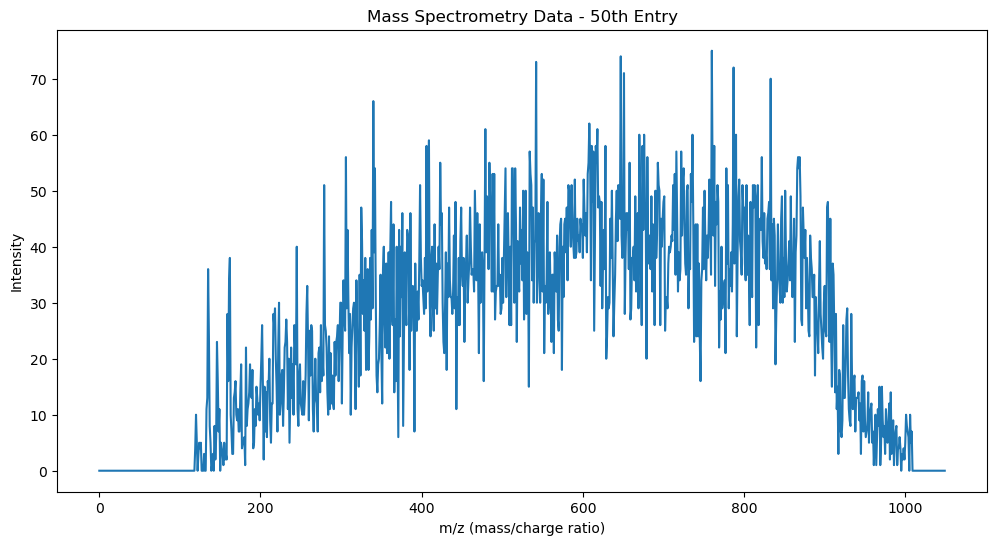

In [237]:
ti02.features.head()
ti02.display_features(226)

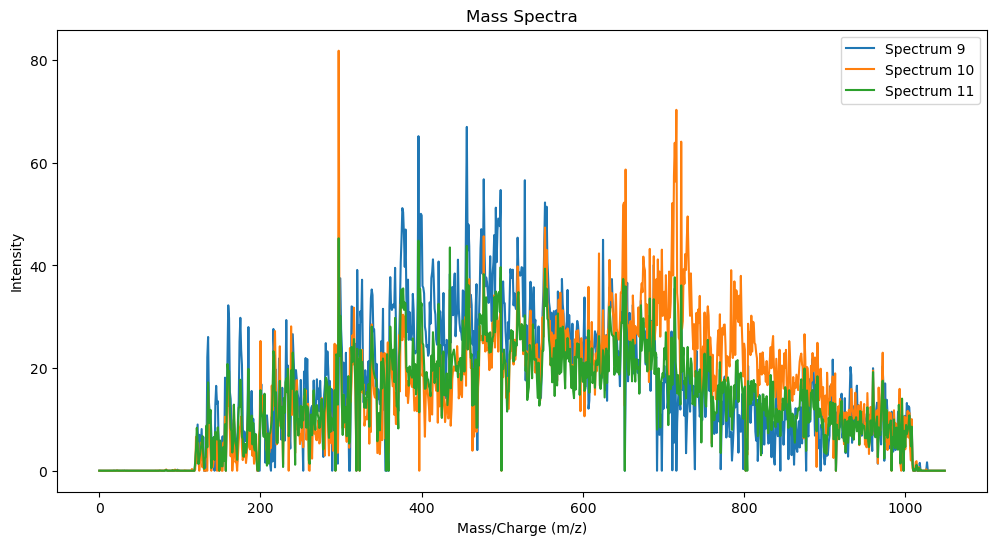

In [173]:
ti02.generate_samples(20)

In [ ]:
 ## Note: I have an issue with understanding loss with WGANS, do not call classification report after training on wgans
    def train_model_wgans(self, num_epochs):
        discriminator = Discriminator()
        generator = Generator()
        self.generator = generator
        _, optimizer_d, optimizer_g = self.setup_optimizers(discriminator, self.generator)

        lambda_gp = 10  # Gradient penalty coefficient
        noise_dim = 100

        for epoch in range(num_epochs):
            for n, (real_samples, _) in enumerate(self.real_data_loader):
                

                for _ in range(5):  # Training discriminator more frequently than generator
                    fake_labels = torch.zeros(self.batch_size, 1)
                    real_labels = torch.ones(self.batch_size, 1)

                    latent_space_samples = torch.randn(self.batch_size, noise_dim)
                    generated_samples = generator(latent_space_samples)
                    
                    generated_samples = torch.tensor(generated_samples, dtype = torch.float32)
                    real_samples = torch.tensor(real_samples, dtype = torch.float32)
                    
                    d_real = discriminator(real_samples)
                    d_fake = discriminator(generated_samples)
                    gradient_penalty = self.compute_gradient_penalty(discriminator, real_samples, generated_samples)

                    loss_d = -torch.mean(d_real) + torch.mean(d_fake) + lambda_gp * gradient_penalty

                    optimizer_d.zero_grad()
                    loss_d.backward()
                    optimizer_d.step()

                # Training the generator
                latent_space_samples = torch.randn(self.batch_size, noise_dim)
                generated_samples = generator(latent_space_samples)
                d_fake = discriminator(generated_samples)

                loss_g = -torch.mean(d_fake)

                optimizer_g.zero_grad()
                loss_g.backward()
                optimizer_g.step()

                if epoch % 10 == 0 and n == 0:
                    print(f"Epoch: {epoch} Loss D.: {loss_d.item()}")
                    print(f"Epoch: {epoch} Loss G.: {loss_g.item()}")


def compute_gradient_penalty(self, D, real_samples, fake_samples):
        alpha = torch.rand(real_samples.size(0), 1, device=real_samples.device)
        alpha = alpha.expand(real_samples.size())
        interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
        interpolates = interpolates.requires_grad_(True)

        d_interpolates = D(interpolates)
        fake = torch.ones(d_interpolates.size(), device=real_samples.device)
        gradients = autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]

        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

    
